In [31]:
import math
import numpy as np 
import matplotlib.pyplot as plt 

In [32]:
#initialize the values
N = 50
D = 1
dx = 1/N
w = 1.8
e = 10**(-5)

In [33]:
def init(N):
    '''
    Initialize a grid with all zeros except on the first row where the value is all ones
    Args:
        -N the size of the grid
    Out: the initial state of the grid
    '''
    grid = np.zeros((N,N))
    grid[0] = np.ones(N)
    return grid

In [49]:
def analytic(Y, t, t_max, D):
        '''
    Function to analytically determine the concentration at point y and time t
    Args: 
        -Y the position on the grid
        -t, the current time t
        -t_max the maximum amount of iterations allowed
        -D, the diffusion coefficient
    Out:
        the concentration value c
    '''
    c = 0
    for i in range(t_max):
        Z_neg = (1 - Y + 2*i) / (2* np.sqrt(D*t))
        Z_pos = (1 + Y + 2*i) / (2* np.sqrt(D*t))
        c = c + math.erfc(Z_neg) - math.erfc(Z_pos)
    return c

1.4 Jacobi iteration

In [35]:
def update_J(Y):
    '''
    The Jacobian method grid update function
    Args:
        -Y the grid at the current timestep
    Out:
        -Y the grid at the next timestep
    '''
    #make a copy of the grid
    Y_prev = np.copy(Y)
    #update the grid at position i, j and take boundary conditions into account
    for j in range(1, len(Y)-1):
        for i in range(len(Y)):
            if i == 0:
                 Y[j,i] = (1/4) * (Y_prev[j+1,i] + Y_prev[j-1,i]+ Y_prev[j,i+1] +Y_prev[j,-1]) 
            elif i == N-1:
                 Y[j,i] = (1/4) * (Y_prev[j+1,i] + Y_prev[j-1,i]+ Y_prev[j,0] +Y_prev[j,i-1]) 
            else:
                 Y[j,i] = (1/4) * (Y_prev[j+1,i] + Y_prev[j-1,i]+ Y_prev[j,i+1] +Y_prev[j,i-1])
    return(Y)  

1.5 The Gauss_Seidel iteration

In [36]:
def update_GS(Y):
    '''
    The Gaus-Seidel method grid update function
    Args:
        -Y the grid at the current timestep
    Out:
        -Y the grid at the next timestep
    '''
    #update the grid at position i, j and take boundary conditions into account
    for j in range(1, len(Y)-1):
        for i in range(len(Y)):
            if i == 0:
                 Y[j,i] =  (1/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,i+1] + Y[j,-1]) 
            elif i == N-1:
                 Y[j,i] =  (1/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,0] + Y[j,i-1]) 
            else:
                 Y[j,i] =  (1/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,i+1] + Y[j,i-1])
    return(Y)  

1.6 Successice Over Relaxation

In [77]:
def update_SOR(Y, w, N = 50, objects = []):
    '''
    The SOR method grid update function
    Args:
        -Y, the grid at the current timestep
        -w, the omega constant
        -N, the size of the grid
        -objects, the range of one or two objects in the grid blocking diffusion
    Out:
        -Y, the grid at the next timestep
    '''
    #update the grid at position i, j and take boundary conditions into account
    for j in range(1, len(Y)-1):
        for i in range(len(Y)):
            if i == 0:
                 Y[j,i] = (1-w)*Y[j,i] + (w/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,i+1] + Y[j,-1]) 
            elif i == N-1:
                 Y[j,i] = (1-w)*Y[j,i] + (w/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,0] + Y[j,i-1]) 
            else:
                 Y[j,i] = (1-w)*Y[j,i] + (w/4) * (Y[j+1,i] + Y[j-1,i] + Y[j,i+1] + Y[j,i-1])
        if len(objects) > 0:
            Y[objects[0,0]:objects[0,1], objects[1,0]:objects[1,1]] = 0
            if len(objects) == 4:
                Y[objects[2,0]:objects[2,1], objects[3,0]:objects[3,1]] = 0    
    return(Y)  

In [142]:
def iterative(model_type, e, w, N=50):
    '''
    The iterative model
    ARGS:
        -model_type, an indicator to use the Jacobian, GS or SOR method
        -e, The epsilon convergence threshold
        -w, The omega for the SOR method
        -N, the size of the model set at 50 standard
    Out:
        -Y, the final state of the grid
        -k, the number of iterations it took to reach Y
        -delta, a list of the convergence value delta at timesteps t
    '''
    #initialize the iterations, grid and convergence list
    Y = init(N)
    delta = []
    k = 1
    #select the method
    if model_type == 0:      # Jacobian iteration
        Y_prev = np.copy(Y)
        Y = update_J(Y)
        #calculate the difference between the last two iterations
        diff = np.abs(Y - Y_prev)
        diff_val = np.amax(diff)
        delta.append(diff_val)
        #until the differnce is smaller than epsilon, update the grid
        while(diff_val > e):
            k = k+1
            Y_prev = np.copy(Y)
            Y = update_J(Y)
            diff = np.abs(Y - Y_prev)
            diff_val = np.amax(diff)
            delta.append(diff_val)
    if model_type == 1:       # Gauss_Seidel iteration
        Y_prev = np.copy(Y)
        Y = update_GS(Y)
        #calculate the difference between the last two iterations
        diff = np.abs(Y - Y_prev)
        diff_val = np.amax(diff)
        delta.append(diff_val)
        #until the differnce is smaller than epsilon, update the grid
        while(diff_val > e):
            k = k+1
            Y_prev = np.copy(Y)
            Y = update_GS(Y)
            diff = np.abs(Y - Y_prev)
            diff_val = np.amax(diff)
            delta.append(diff_val)
    if model_type == 2:      # Successice Over Relaxation iteration
        Y_prev = np.copy(Y)
        Y = update_SOR(Y, w, N)
        #calculate the difference between the last two iterations
        diff = np.abs(Y - Y_prev)
        diff_val = (np.amax(diff))
        delta.append(diff_val)
        #until the differnce is smaller than epsilon, update the grid
        while(diff_val > e):
            k = k+1
            Y_prev = np.copy(Y)
            Y = update_SOR(Y, w, N)
            diff = np.abs(Y - Y_prev)
            diff_val = (np.amax(diff))
            delta.append(diff_val)
    return(Y, k, delta)

In [ ]:
#Run the three methods
grid_0, total_iterations_0, delta_0 = iterative(0, e, w)
grid_1, total_iterations_1, delta_1 = iterative(1, e, w)
grid_2, total_iterations_2, delta_2 = iterative(2, e, w)

Jacobian iteration till convergence:  4068
Gaus-Seidel iteration till convergence:  2361
SOR iteration till convergence:  366


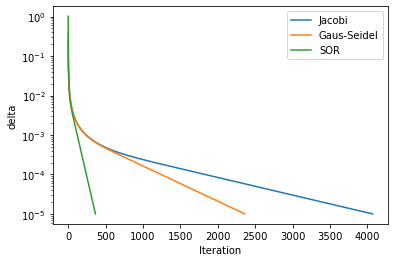

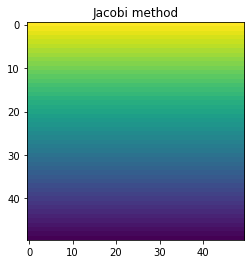

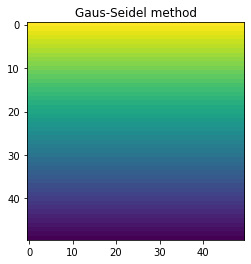

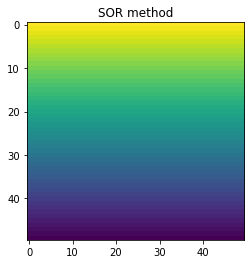

In [145]:
#plot the convergence and show the final state of the grid
print("Jacobian iteration till convergence: " , total_iterations_0)
plt.plot(delta_0, label = "Jacobi")
print("Gaus-Seidel iteration till convergence: " , total_iterations_1)
plt.plot(delta_1, label = "Gaus-Seidel")
print("SOR iteration till convergence: " , total_iterations_2)
plt.plot(delta_2, label = "SOR")
plt.xlabel("Iteration")
plt.ylabel("delta")
plt.yscale("log")
plt.legend()
plt.show()
plt.imshow(grid_0)
plt.title("Jacobi method")
plt.show()
plt.imshow(grid_1)
plt.title("Gaus-Seidel method")
plt.show()
plt.imshow(grid_2)
plt.title("SOR method")
plt.show()

In [55]:
#Create the analytical values of the concentration on the grid
C_list = []
for y in np.arange(0, 1, 0.01):
    C = analytic(y, 1, 50, D)
    C_list.append(C)
C_list.reverse() # 

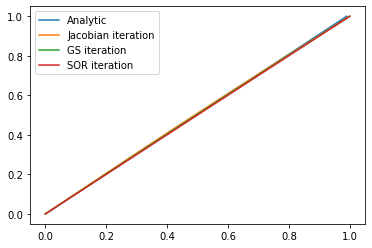

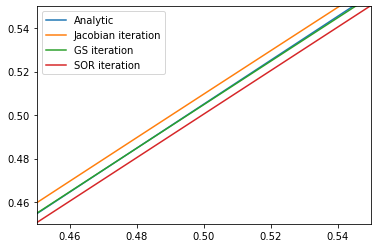

In [143]:
#plot the analytical and iterative method concentrations
plt.plot(C_list, np.linspace(1, 0, 100), label = "Analytic")
plt.plot(grid_0[:,0], np.linspace(1,0,N), label = "Jacobian iteration")
plt.plot(grid_1[:,0], np.linspace(1,0,N), label = "GS iteration")
plt.plot(grid_2[:,0], np.linspace(1,0,N), label = "SOR iteration")
plt.legend()
plt.show()

#plot the analytical and iterative method concentrations ate a close up
plt.plot(C_list, np.linspace(1, 0, 100), label = "Analytic")
plt.plot(grid_0[:,0], np.linspace(1,0,N), label = "Jacobian iteration")
plt.plot(grid_1[:,0], np.linspace(1,0,N), label = "GS iteration")
plt.plot(grid_2[:,0], np.linspace(1,0,N), label = "SOR iteration")
plt.ylim(0.45, 0.55)
plt.xlim(0.45, 0.55)
plt.legend()
plt.show()

In [89]:
#Run the SOR method for values of omega between 1.7 and 2 and grid size between 50 and 150
w_list = np.arange(1.7,2,0.05)
N_list = np.arange(50, 150, 5)
iter_list = np.zeros((len(w_list), len(N_list)))
delta_list = []
for i in range(len(w_list)):
    for j in range(len(N_list)):
        grid, k, delta = iterative(2, e, w_list[i], N_list[j])
        iter_list[i, j] = k
        delta_list.append(delta)

(50, 50)
50
(55, 55)
55
(60, 60)
60
(65, 65)
65
(70, 70)
70
(75, 75)
75
(80, 80)
80
(85, 85)
85
(90, 90)
90
(95, 95)
95
(100, 100)
100
(105, 105)
105
(110, 110)
110
(115, 115)
115
(120, 120)
120
(125, 125)
125
(130, 130)
130
(135, 135)
135
(140, 140)
140
(145, 145)
145
(50, 50)
50
(55, 55)
55
(60, 60)
60
(65, 65)
65
(70, 70)
70
(75, 75)
75
(80, 80)
80
(85, 85)
85
(90, 90)
90
(95, 95)
95
(100, 100)
100
(105, 105)
105
(110, 110)
110
(115, 115)
115
(120, 120)
120
(125, 125)
125
(130, 130)
130
(135, 135)
135
(140, 140)
140
(145, 145)
145
(50, 50)
50
(55, 55)
55
(60, 60)
60
(65, 65)
65
(70, 70)
70
(75, 75)
75
(80, 80)
80
(85, 85)
85
(90, 90)
90
(95, 95)
95
(100, 100)
100
(105, 105)
105
(110, 110)
110
(115, 115)
115
(120, 120)
120
(125, 125)
125
(130, 130)
130
(135, 135)
135
(140, 140)
140
(145, 145)
145
(50, 50)
50
(55, 55)
55
(60, 60)
60
(65, 65)
65
(70, 70)
70
(75, 75)
75
(80, 80)
80
(85, 85)
85
(90, 90)
90
(95, 95)
95
(100, 100)
100
(105, 105)
105
(110, 110)
110
(115, 115)
115
(120, 120)

KeyboardInterrupt: 

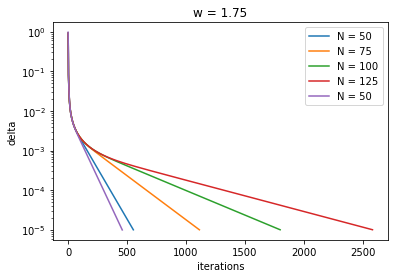

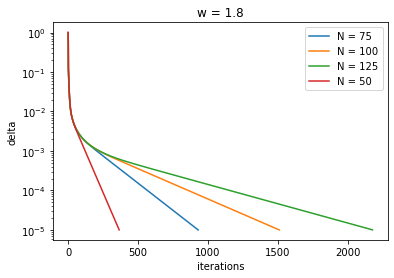

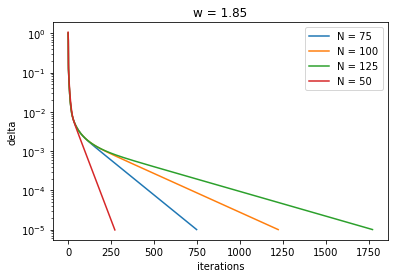

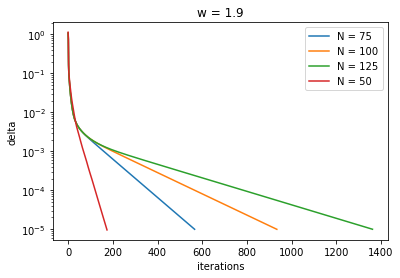

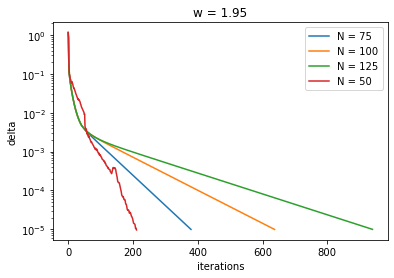

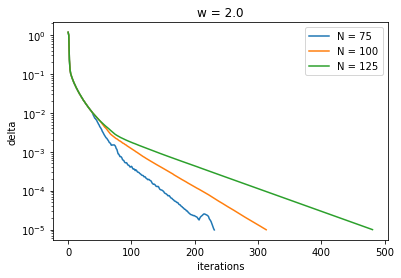

In [130]:
#plot the convergence of the SOR method for values of omega between 1.7 and 2 and grid size between 50 and 150
for i in range(len(delta_list)):
    if i %5 == 0:
        nindex = i%len(N_list)
        plt.plot(delta_list[i], label = "N = {}".format(N_list[nindex]))
    if i%len(N_list) == 0 and i>0:
        index = int(i/len(N_list))
        w = w_list[index]
        w = round(w, 2)
        plt.title("w = {}".format(w))
        plt.yscale("log")
        plt.xlabel("iterations")
        plt.ylabel("delta")
        plt.legend()
        plt.show()
plt.title("w = {}".format(w_list[-1]))
plt.yscale("log")
plt.xlabel("iterations")
plt.ylabel("delta")
plt.legend()

plt.show()

K)

In [103]:
def SOR_objects(Y, w, ob):
    '''
    The SOR method for when objexts are present
    ARGS:
        -Y, the grid at the current timestep
        -w, the omega constant
        -ob, the range of one or two objects in the grid blocking diffusion
    Out:
        -Y, the grid at the next timestep
        -k, the amont of iterations to converge
    '''
    Y_prev = np.copy(Y)
    Y = update_SOR(Y, w, objects = ob)
    #calculate the difference between the last two iterations
    diff = np.abs(Y - Y_prev)
    diff_val = (np.amax(diff))
    k = 1
    #until the differnce is smaller than epsilon, update the grid
    while(diff_val > e):
        k=k+1
        Y_prev = np.copy(Y)
        Y = update_SOR(Y, w, objects = ob)
        diff = np.abs(Y - Y_prev)
        diff_val = (np.amax(diff))
    return(Y, k)

243


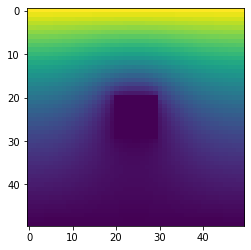

258


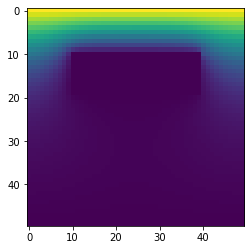

255


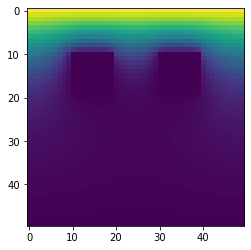

236


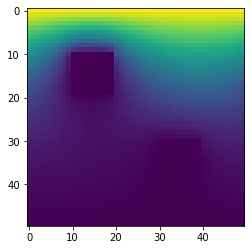

In [148]:
#initialize a grid
Y = init(N)
#create the object
ob = np.array([[20,30], [20,30]])
#run the SOR method
grid_obj, iterations = SOR_objects(Y,w, ob)
#show the number of iterations and the final state of the grid
print (iterations)
plt.imshow(grid_obj)
plt.show()

#initialize a grid
Y = init(N)
#create the object
ob = np.array([[10, 20], [10, 40]])
#run the SOR method
grid_obj, iterations = SOR_objects(Y,w, ob)
#show the number of iterations and the final state of the grid
print (iterations)
plt.imshow(grid_obj)
plt.show()

#initialize a grid
Y = init(N)
#create the object
ob = np.array([[10, 20], [10, 20], [10, 20], [30, 40]])
#run the SOR method
grid_obj, iterations = SOR_objects(Y,w, ob)
#show the number of iterations and the final state of the grid
print (iterations)
plt.imshow(grid_obj)
plt.show()

#initialize a grid
Y = init(N)
#create the object
ob = np.array([[10, 20], [10, 20], [30, 40], [30, 40]])
#run the SOR method
grid_obj, iterations = SOR_objects(Y,w, ob)
#show the number of iterations and the final state of the grid
print (iterations)
plt.imshow(grid_obj)
plt.show()